# **Text Classification - Sentiment Analysis**

This is a Binary Classifier to Peform Sentiment Analysis on the IMDB Dataset.

In [38]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [39]:
print(tf.__version__)

2.4.1


## **Sentiment Analysis**

The notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of **binary—or two-class—classification**, an important and widely applicable kind of machine learning problem.

Dataset used here is the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into **25,000 reviews for training** and **25,000 reviews for testing**. The training and testing sets are balanced, which means they contain an equal number of positive and negative reviews.

## 1. Download the IMDB Dataset.

In [40]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [41]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'train', 'README']

In [42]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'unsupBow.feat',
 'neg',
 'unsup',
 'pos',
 'labeledBow.feat',
 'urls_pos.txt',
 'urls_unsup.txt']

The aclImdb/train/pos and aclImdb/train/neg directories contain many text files, each of which is a single movie review. Sample file from one of them.

In [43]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## 2. Load the Dataset

Load the data and prepare it into a format suitable for training.
To prepare a dataset for binary classification, you will need two folders on disk, corresponding to **class_a** and **class_b**. These will be the positive and negative movie reviews, which can be found in aclImdb/train/pos and aclImdb/train/neg.
+  As the IMDB dataset contains additional folders, remove them before using this utility.

In [44]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Now use the text_dataset_from_directory utility to create a labeled **tf.data.Dataset**. tf.data is a powerful collection of tools for working with data.

+ When running a machine learning experiment, it is a best practice to divide your dataset into three splits: **train, validation, and test**.

+ The IMDB dataset has already been divided into train and test, but it lacks a validation set.So, create a validation set using an 80:20 split of the training data by using the validation_split argument below.

In [45]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


There are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. 
+ We can train a model by passing a dataset directly to model.fit. 
+ Before that, we can also iterate over the dataset and print out a few examples as follows.

In [46]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

+ Reviews contain raw text 
+ The labels are 0 or 1. 
+ To see which of these correspond to positive and negative movie reviews, check the class_names property on the dataset.

In [47]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Create Validation Set
+ Next, create a validation and test dataset. Use the remaining 5,000 reviews from the training set for validation.

In [48]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [49]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## 3. Prepare the Dataset for Training

Here, standardize, tokenize, and vectorize the data using the helpful **preprocessing.TextVectorization** layer

+ Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.

+ Tokenization refers to splitting strings into tokens.

+ Vectorization refers to converting tokens into numbers so they can be fed into a neural network.

+ All of these tasks can be accomplished with this layer.

The reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the **TextVectorization layer**. So, write a custom standardization function to remove the HTML.

In [50]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Now, create a TextVectorization layer. This layer is to standardize, tokenize, and vectorize our data. Set the output_mode to int to create unique integer indices for each token.

+ Define some constants for the model, like an explicit maximum **sequence_length**, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [51]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Call **adapt** to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [52]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Create a function to see the result of using this layer to preprocess some data.

In [53]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [54]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

Here, each token has been replaced by an integer. Lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [55]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print(" 301 ---> ",vectorize_layer.get_vocabulary()[301])
print(" 7158 ---> ",vectorize_layer.get_vocabulary()[7158])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
 301 --->  himself
 7158 --->  trauma
Vocabulary size: 10000


To train your model. As a final preprocessing step, apply the TextVectorization layer which is created earlier to the train, validation, and test dataset.

In [56]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## 4. Configure the Dataset for Perfomance.

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

+ *.cache()* keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model.

+ *.prefetch()* overlaps data preprocessing and model execution while training.

In [57]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Create Model

Time to create the Model.

In [27]:
embedding_dim = 16

In [58]:
model = tf.keras.Sequential([
                             layers.Embedding(max_features + 1, embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(4)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier.

1. The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

3. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

4. The last layer is densely connected with a single output node.

## 6. Loss Function and Optimizer
A model needs a loss function and an optimizer for training.

+ Loss Function =  **losses.BinaryCrossentropy** --- Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation)

+ Optimizer = "adam"





In [59]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## 7. Train the Model.

Train the model by passing the dataset object to the fit method.


In [60]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 12s 19ms/step - loss: 1.0553 - binary_accuracy: 0.4982 - val_loss: 0.6726 - val_binary_accuracy: 0.5000
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.6607 - binary_accuracy: 0.5000 - val_loss: 0.6011 - val_binary_accuracy: 0.5000
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5896 - binary_accuracy: 0.5000 - val_loss: 0.5290 - val_binary_accuracy: 0.5000
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5189 - binary_accuracy: 0.5000 - val_loss: 0.4647 - val_binary_accuracy: 0.5000
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4551 - binary_accuracy: 0.5000 - val_loss: 0.4135 - val_binary_accuracy: 0.5002
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3985 - binary_accuracy: 0.5005 - val_loss: 0.3761 - val_binary_accuracy: 0.5013
Epoch 7/10
625/625 [==============================] - 5s 8ms/s

## 8. Evaluate the Model

See how the model performs. Two values will be returned. 
+ Loss (a number which represents error, lower values are better), and 
+ Accuracy.

In [61]:
loss, accuracy = model.evaluate(test_ds)

print("Loss:", loss)
print("Accuracy:", accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3241 - binary_accuracy: 0.5076
Loss: 0.3241260349750519
Accuracy: 0.5076000094413757


Accuracy is about 50% only

## 9. Create plot of Accuracy and Loss over time.

model.fit() returns a History object that contains a dictionary with everything that happened during training.

In [62]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation.

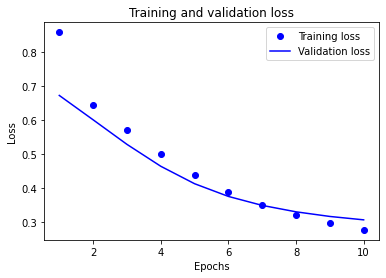

In [63]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

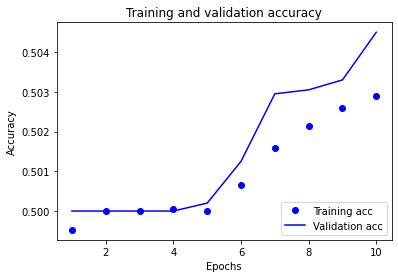

In [64]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

+ Training loss decreases with each epoch. Training acc increases but not in an exponential way as seen in the binary classification. So, here the training acc is low in this model.

+ The training accuracy is less that the validation acc here in the second figure. For multi class classification.

### note:-

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the **tf.keras.callbacks.EarlyStopping** callback.

## 10. Export Model.

In the code above, we have applied the **TextVectorization** layer to the dataset before feeding text to the model. 
+ If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. 
+ To do so, you can create a new model using the weights you just trained.

In [65]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3323 - accuracy: 0.8615
0.8678799867630005


### Inference on New Data.

+ Get predictions for new examples, call **model.predict()**

In [66]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

In [67]:
export_model.predict(examples)

array([[8.4011674e-01, 8.9703727e-01, 8.1726909e-04, 1.2494028e-03],
       [8.7778181e-01, 8.6565423e-01, 8.1047416e-04, 1.2416840e-03],
       [8.9250696e-01, 8.4788930e-01, 8.1053376e-04, 1.2443662e-03]],
      dtype=float32)